#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [3]:
# Проверим в хронологичном ли порядке расположены даты и посмотрим информацию о данных:
display(df.index.is_monotonic)
display(df.head(10))
df.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


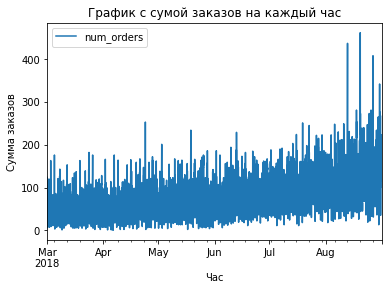

In [4]:
#Сделаем ресемплирование с суммой заказов на каждый час по часам и посмотрим график:
df = df.resample('1H').sum() 
df.plot()
plt.title('График с сумой заказов на каждый час')
plt.xlabel('Час')
plt.ylabel('Сумма заказов')
plt.show()

In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**ВЫВОД**
* В наборе данных 26496 наблюдений и 2 столбца
Признаки:
* datetime — отсечка временного периода, состоит из даты и времени
* num_orders — количество заказов

* Даны заказы такси с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
* пропусков нет
* стандартное отклонение 45
* данные ресемплированы по 1 часу, по условию задачи, расположены в хронологическом порядке

## Анализ

Посмотрим на скользящую среднюю с шириной окна 100:

<AxesSubplot:xlabel='datetime'>

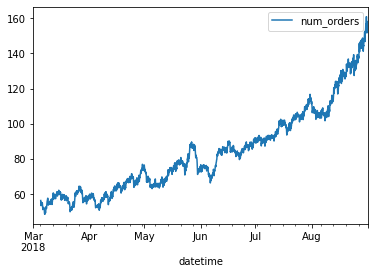

In [6]:
df.rolling(100).mean().plot()

Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд сползающий вверх.

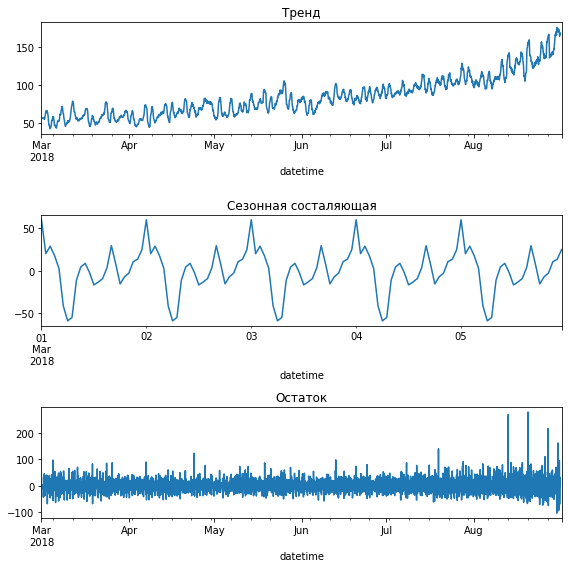

In [7]:
# Разложим временной ряд на тренд и сезоную составляющие
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за неделю:

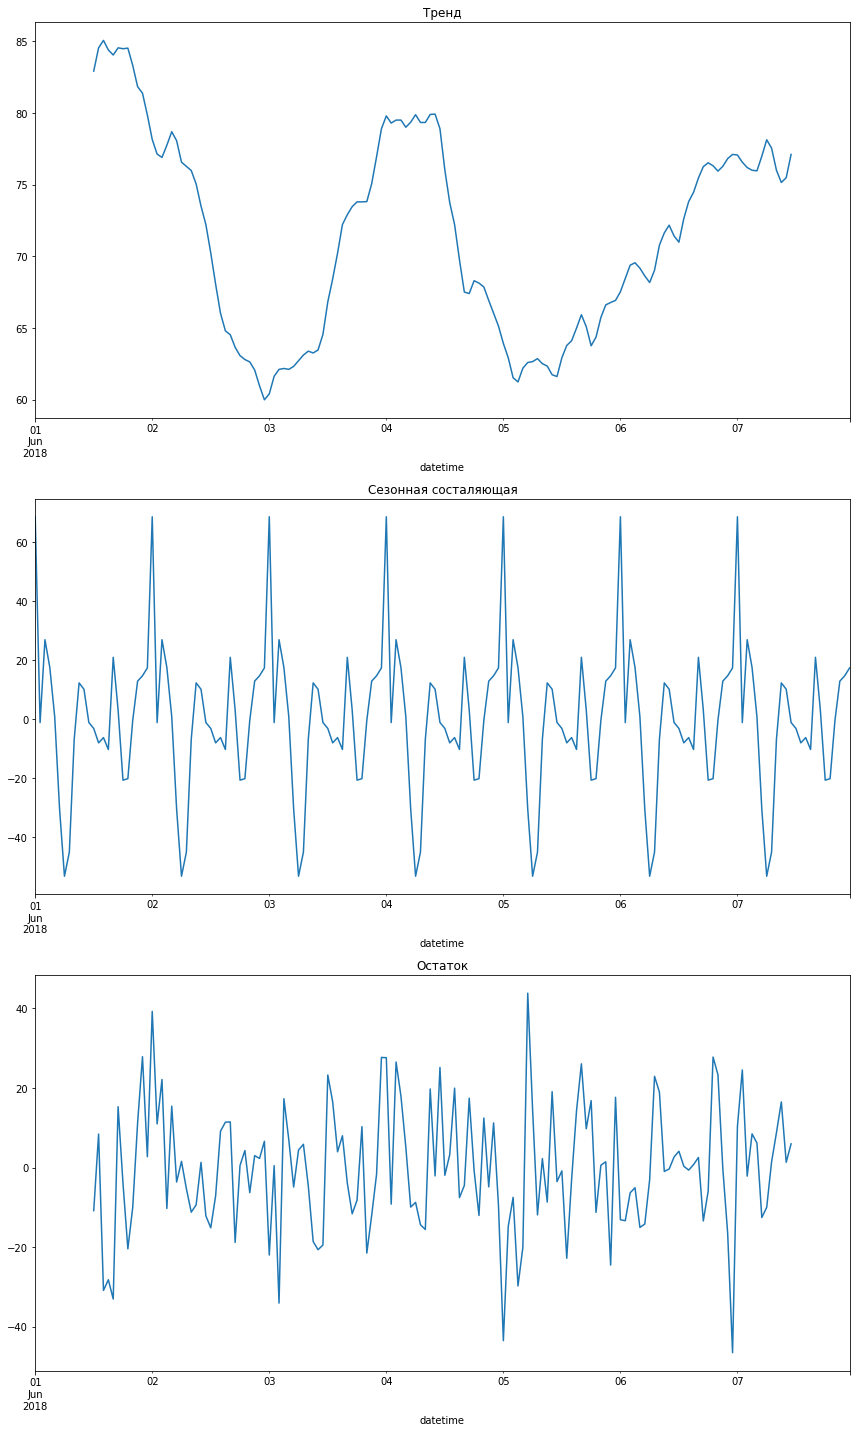

In [8]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная состаляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

Рассмотрим сезонность подробней. В течении дня.

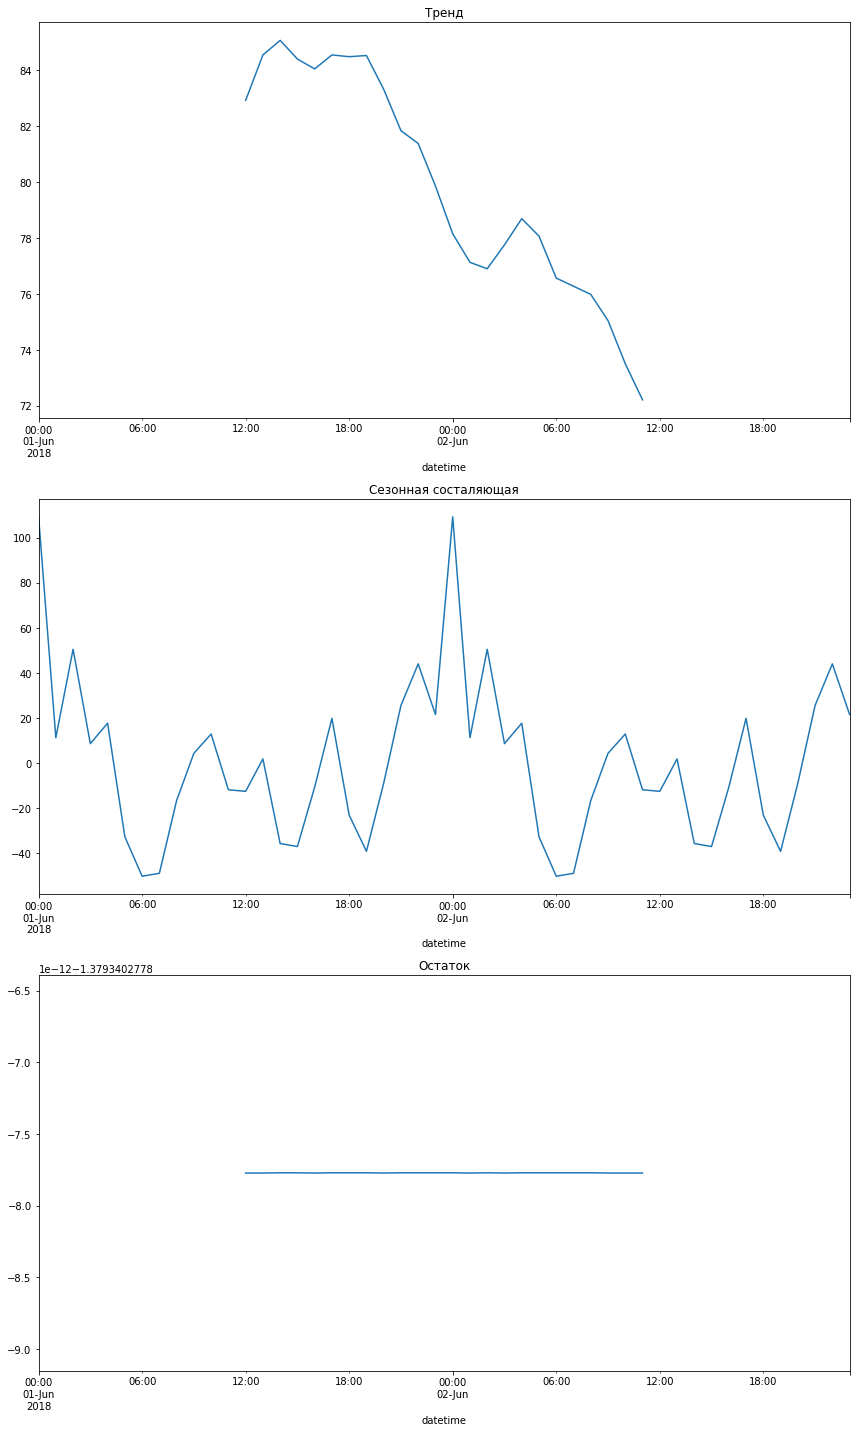

In [9]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-02'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная состаляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Наблюдается явная суточная сезонность. Как видно из графика, реже заказывают такси в 6 утра и пик заказов приходится на полночь. Возможно это связано с работой общественного транспорта.

Создам функцию make_features которая:
* Добавляет фактор месяца и фактор дня исходя из общего тренда
* Добавляет фактор дня недели, так как на графике недели видим большую вариацию добавляет фактор часа, так как прослеживаем пики активности в течении суток Добавляет lag


In [10]:
data = df.copy(deep=True)

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Применим функцию с лагом до 24 часов и 100-м скользящим средним:

In [12]:
make_features(data, 24, 100)
data.shape

(4416, 30)

In [13]:
data.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data = data.dropna()

In [15]:
data.shape

(4316, 30)

In [16]:
data.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,3,5,4,0,51.0,32.0,176.0,86.0,68.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,3,5,5,0,34.0,51.0,32.0,176.0,86.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,3,5,6,0,16.0,34.0,51.0,32.0,176.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,3,5,7,0,3.0,16.0,34.0,51.0,32.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,3,5,8,0,14.0,3.0,16.0,34.0,51.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


**ВЫВОД**
Проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:

- Графики показывают высокую частотность и суточную сезонность, уменьшили интервал и посмотрели за неделю
- За неделю явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

Написана функция для подготовки признаков для будущего обучения модели, где выделены календарные признаки:
* год
* месяц
* день
* день недели
* час(так как ресемплинг идет по часам)

Также добавили и другие признаки:
* отстающие значения и скользящее среднее
* со смещением,чтобы не было подсматривания данных


## Обучение

Поделим данные на фичи и таргеты:

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 29)
(432, 29)
(3884,)
(432,)


Пропишу функцию для расчета метрики RMSE:

In [19]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Линейная регрессия

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [20]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаю модель
regression.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.20064200976903
CPU times: user 115 ms, sys: 221 ms, total: 336 ms
Wall time: 333 ms


### RandomForestRegressor

In [21]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor(random_state=42)
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 30, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 11min, sys: 1.53 s, total: 11min 1s
Wall time: 11min 2s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f483f2512e0>,
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(1, 30, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [22]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 25}
10.67909317043468
_______________
CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 28 ms


### CatBoost

In [23]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'n_estimators': [5, 30, 5],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

Learning rate set to 0.5
0:	learn: 24.4532137	total: 48.6ms	remaining: 194ms
4:	learn: 18.6867132	total: 55.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.8103184	total: 2.42ms	remaining: 9.68ms
4:	learn: 21.0403995	total: 9.56ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.0594040	total: 2.6ms	remaining: 10.4ms
4:	learn: 22.2291334	total: 10.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.4532137	total: 1.64ms	remaining: 47.5ms
29:	learn: 12.9324641	total: 52ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.8103184	total: 3.25ms	remaining: 94.1ms
29:	learn: 16.2574116	total: 69.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.0594040	total: 3ms	remaining: 87.1ms
29:	learn: 18.1898080	total: 60.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.4532137	total: 1.48ms	remaining: 5.91ms
4:	learn: 18.6867132	total: 7.01ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.8103184	total: 1.99ms	remaining: 7.97ms
4:	learn: 21.0403995	total: 8.

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f483fa2e660>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f483f8c7520>,
             param_grid={'depth': [4, 6, 10], 'n_estimators': [5, 30, 5]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [24]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 4, 'n_estimators': 30}
20.483723270499738
_______________
CPU times: user 0 ns, sys: 3.28 ms, total: 3.28 ms
Wall time: 2.39 ms


**ВЫВОД:**

- Среднее качество модели линейной регрессии на кросс-валидации: 28.20

- RandomForestRegressor RMSE: 10.67

- CatBoost RMSE: 20.48

Таким образом, лучшая модель RandomForestRegressor. Проведм тестирование

## Тестирование

In [25]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=19,
                                     min_samples_leaf = 1,
                                     min_samples_split = 6,
                                     n_estimators = 25)

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 44.695
CPU times: user 1.12 s, sys: 16 µs, total: 1.12 s
Wall time: 1.12 s


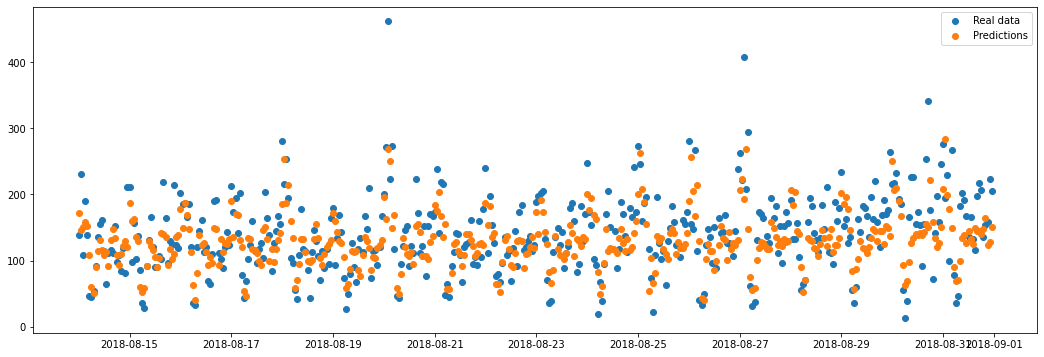

In [26]:
plt.figure(figsize=(18, 6))
plt.scatter(y=target_test, x=target_test.index, label='Real data')
plt.scatter(y=forest_model_predictions, x=target_test.index, label='Predictions')
plt.legend(loc='upper right')
plt.show()

**ВЫВОД**:

Значение метрики RMSE модели Случайного леса на тестовой выборке: 44.695

**ОБЩИЙ ВЫВОД:**

При выполнении проекта проделана следующая работа:

- На первом этапе произведена загрузка данных и их подготовка для обучения моделей.


- Проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:
- Графики показывают высокую частотность и суточную сезонность, уменьшили интервал и посмотрели за неделю
- За неделю явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

* На следующем этапе к датасету были добавлены дополнительные признаки, а именно 
год, месяц, день, день недели, час(так как ресемплинг идет по часам), "отстающие значения" и скользящее среднее. 

* На дополнном датасете подобраны оптимальные гиперпараметры для моделей: 

- Среднее качество модели линейной регрессии на кросс-валидации: 28.20

- RandomForestRegressor RMSE: 10.67

- CatBoost RMSE: 20.48

Таким образом, лучшая модель RandomForestRegressor. 

* На заключительном этапе проведено тестирование модели  RandomForestRegressor. Значение метрики RMSE модели Случайного леса на тестовой выборке: 44.695

Требование о значении метрики RMSE (не более 48) выполнено.
